# Imports for the project:

In [1]:
import sys
import os
print(os.getcwd())
sys.path.append(os.path.abspath("../"))

c:\Users\Usuario\REPO_BOOTCAMP\ML_Adidas-Forecast\src\results_notebook


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

import utils.bootcampviztools as bt
import utils.funciones_eda as fe
import utils.toolbox_ML as tb


Paquete utils cargado correctamente


# ✅ Step 1: Objective of the project.


### ADIDAS AND ITS RETAILERS IN THE UNITED STATES 🔎

Adidas wants to know a reasonable prediction of how much the retailer shops will be selling in order to know if the products they are ordering are appropriate for their level of turnover. It is very important that the product is in the most efficient place possible and for that we have to predict it.

At the same time, they want to set up a logistics system for the US states where there is more demand for the product. This would prevent stock-outs and improve costs, as the best-selling product in each state would be closer to these distribution shops.

🤔 QUESTIONS WE ASK OURSELVES 🤔.

A. PREDICTING THE BILLING OF DISTRIBUTING STORES 💵 (pt. I)

B. PREVENTING STOCK-OUT AND MARKET RESEARCH 🚛 (pt. II)
- Which market is the booming market for these years?
- Are there any markets we should be aware of that are declining?
- Will shops meet the minimum desired turnover?
- Does turnover vary with seasonality?
- In which regions should we have a stronger logistics centre for the future?
- How much stock per category should be available in each region?

🙋‍♂️ *The project contains **two parts**. As it is a large project, the first part **(A)** will be the one submitted for qualification. Part II **(B)** will be answered in the coming weeks on a personal basis.

👁‍🗨 *The role of ‘Business’ is very important in this project. There are many nuances that depending on what ‘Business’ sees fit, it would be done one way or another.

# ✅ Step 2: Obtaining data.


In [3]:
file_path = "../data/adidas_sales.csv"

In [4]:
df = pd.read_csv(file_path)
df.head(5)

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Sales Method
0,Walmart,1128299,6/17/2021,Southeast,Florida,Orlando,Women's Apparel,$103.00,218,"2,245","$1,257",Online
1,West Gear,1128299,7/16/2021,South,Louisiana,New Orleans,Women's Apparel,$103.00,163,"1,679",$806,Online
2,Sports Direct,1197831,8/25/2021,South,Alabama,Birmingham,Men's Street Footwear,$10.00,700,"7,000","$3,150",Outlet
3,Sports Direct,1197831,8/27/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,575,"8,625","$3,881",Outlet
4,Sports Direct,1197831,8/21/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,475,"7,125","$3,206",Outlet


---------
At a quick view we see:
- Spaced columns.
- Error in the calculation of ***"Total Sales ’***.
- Columns that we are going to clean to have the DataFrame as functional as possible.

And more things that we will see in the next step

# ✅ Step 3: Data cleansing - Corrections - Target.


- We solve the spaced columns:

In [5]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   retailer          9641 non-null   object
 1   retailer_id       9641 non-null   int64 
 2   invoice_date      9641 non-null   object
 3   region            9641 non-null   object
 4   state             9641 non-null   object
 5   city              9641 non-null   object
 6   product           9641 non-null   object
 7   price_per_unit    9639 non-null   object
 8   units_sold        9641 non-null   object
 9   total_sales       9641 non-null   object
 10  operating_profit  9641 non-null   object
 11  sales_method      9641 non-null   object
dtypes: int64(1), object(11)
memory usage: 904.0+ KB


- Missing values in ***"price_per_unit “*** but first we will fix the calculation error in ***”total_sales ’***.
- We have object type in all columns, we need to transform some of them to numeric.
- We want to transform ***"invoice_date ’*** to datetime.
- Let's remove columns not relevant to the project.

In [7]:
df[df.index == 78]

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
78,West Gear,1128299,1/12/2021,West,California,San Francisco,Men's Street Footwear,$41.00,338,"1,386",$527,Outlet


- If we look at the *sample* we can see that the multiplication in ***"total_sales ’*** (*price_per_unit* and *units_sold*) is not correct. Let's do it again and correct the dollar sign. We will make it a numeric type. Finally we will add two decimals in the columns.

In [8]:
df["price_per_unit"] = df["price_per_unit"].str.replace("$", "")
df["price_per_unit"] = pd.to_numeric(df["price_per_unit"], errors="coerce")

In [9]:
# Visión general de los datos
df.sample(6)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
9541,Foot Locker,1185732,7/25/2021,Midwest,Nebraska,Omaha,Women's Apparel,55.0,200,"11,000","$5,500",Outlet
6386,Foot Locker,1185732,11/21/2021,Northeast,Maryland,Baltimore,Men's Apparel,56.0,31,174,$76,Online
8551,West Gear,1128299,5/18/2021,South,Louisiana,New Orleans,Women's Street Footwear,50.0,400,"20,000","$8,000",In-store
5911,Foot Locker,1185732,12/9/2020,Midwest,Minnesota,Minneapolis,Women's Apparel,39.0,52,203,$116,Online
4308,Amazon,1185732,6/22/2021,Southeast,Kentucky,Louisville,Women's Apparel,52.0,101,525,$273,Online
3381,Amazon,1185732,10/22/2021,Southeast,Kentucky,Louisville,Men's Street Footwear,53.0,126,668,$367,Online


In [10]:
df["units_sold"] = pd.to_numeric(df["units_sold"].str.replace(",", ""),errors="coerce")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9639 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   object 
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 904.0+ KB


Being numeric columns we could already calculate the correct ‘total_sales’ but let's visualise the nulls first before touching the data.

In [12]:
df[df.isnull().any(axis=1)]

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
6725,Foot Locker,1185732,1/29/2020,Northeast,New York,New York,Men's Apparel,NaN,850,"51,000","$15,300",Outlet
7882,Sports Direct,1197831,7/29/2020,South,Texas,Houston,Men's Apparel,NaN,500,"20,000","$6,000",Outlet


---------
🤔 This would be a question for ‘Business’ because we have two solutions to deal with these nulls.
1. We understand that the division of ***"total_sales “*** / ***”units_sold “*** give the result of ***”price_per_unit ’***.
2. We have seen that there are values of ***"total_sales ’*** that were not well calculated and they all have in common the missing last digit.

Since there are two missing values, let's rely on the values we have from the dataset and do option 1.

In [13]:
df["total_sales"] = pd.to_numeric(df["total_sales"].str.replace(",", ""),errors="coerce")


In [14]:
df["price_per_unit"] = df["price_per_unit"].fillna(df["total_sales"] / df["units_sold"])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retailer          9641 non-null   object 
 1   retailer_id       9641 non-null   int64  
 2   invoice_date      9641 non-null   object 
 3   region            9641 non-null   object 
 4   state             9641 non-null   object 
 5   city              9641 non-null   object 
 6   product           9641 non-null   object 
 7   price_per_unit    9641 non-null   float64
 8   units_sold        9641 non-null   int64  
 9   total_sales       9641 non-null   int64  
 10  operating_profit  9641 non-null   object 
 11  sales_method      9641 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 904.0+ KB


- We calculate the correct values of ***"total_sales ’***.

In [16]:
df["total_sales"] = df["price_per_unit"] * df["units_sold"]

In [17]:
df.sample(5)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
8470,West Gear,1128299,1/16/2020,West,Nevada,Las Vegas,Women's Street Footwear,55.0,400,22000.0,"$8,800",Outlet
6693,Sports Direct,1185732,7/15/2021,Midwest,Michigan,Detroit,Men's Street Footwear,60.0,900,54000.0,"$27,000",In-store
393,Foot Locker,1185732,3/7/2020,Northeast,New York,New York,Women's Athletic Footwear,47.0,261,12267.0,$552,Online
9008,Amazon,1185732,6/19/2021,Northeast,New Hampshire,Manchester,Men's Apparel,65.0,325,21125.0,"$6,338",In-store
7763,Sports Direct,1197831,9/25/2021,South,Alabama,Birmingham,Men's Athletic Footwear,30.0,525,15750.0,"$7,875",Outlet


- Delete rows with result 0 in total_sales

In [18]:
df = df[df["total_sales"] != 0]

- DateTime for ***"invoice_date ’*** and we order the DataFrame

In [19]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"])

In [20]:
df = df.sort_values(by="invoice_date")
df.head(8)

,retailer,retailer_id,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,sales_method
9189,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0,"$6,188",Outlet
4937,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0,$141,Outlet
30,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0,$679,Outlet
4908,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0,$243,Online
79,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.0,336,15792.0,$963,Online
6562,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,60000.0,"$30,000",In-store
6588,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,50000.0,"$15,000",In-store
117,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,36.0,320,11520.0,$403,Outlet


In [21]:
df.isnull().sum()

retailer            0
retailer_id         0
invoice_date        0
region              0
state               0
city                0
product             0
price_per_unit      0
units_sold          0
total_sales         0
operating_profit    0
sales_method        0
dtype: int64

- We remove irrelevant columns and make a backup copy of the dataset.

In [22]:
df = df.drop(columns=["retailer_id", "operating_profit", "sales_method"], errors="ignore")

# ‘retailer_id’ is removed because we already have a ‘retailer’ column.
# ‘operation_profit’ is removed because we have no context on the expenses to really understand the profit.
# ‘sales_method’ is removed because we have understood that they are all physical shops.

- A quick check to see if everything is in order

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9637 entries, 9189 to 9605
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9637 non-null   object        
 1   invoice_date    9637 non-null   datetime64[ns]
 2   region          9637 non-null   object        
 3   state           9637 non-null   object        
 4   city            9637 non-null   object        
 5   product         9637 non-null   object        
 6   price_per_unit  9637 non-null   float64       
 7   units_sold      9637 non-null   int64         
 8   total_sales     9637 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 752.9+ KB


In [24]:
df.region.value_counts()

region
West         2446
Northeast    2376
Midwest      1865
South        1726
Southeast    1224
Name: count, dtype: int64

In [25]:
df.state.value_counts()

state
Texas             430
California        430
Florida           360
New York          360
Pennsylvania      216
Arkansas          216
Oklahoma          216
Rhode Island      216
Oregon            216
Virginia          216
Vermont           216
Mississippi       216
Idaho             216
Utah              216
New Hampshire     216
Arizona           216
Tennessee         216
Massachusetts     216
New Mexico        216
Alabama           216
Nevada            216
Connecticut       216
Georgia           216
Louisiana         216
Kentucky          144
Colorado          144
Washington        144
West Virginia     144
Wyoming           144
Minnesota         144
Montana           144
Iowa              144
Ohio              144
North Dakota      144
Alaska            144
Wisconsin         144
Michigan          144
Maryland          144
New Jersey        144
Indiana           144
Hawaii            144
South Dakota      144
Maine             144
North Carolina    144
Kansas            144
Miss

In [26]:
df.city.value_counts()

city
Portland          360
Charleston        288
Little Rock       216
New York          216
Boston            216
Oklahoma City     216
Providence        216
Richmond          216
Burlington        216
Philadelphia      216
Orlando           216
Jackson           216
Salt Lake City    216
Manchester        216
Phoenix           216
Los Angeles       216
Knoxville         216
Birmingham        216
Boise             216
Albuquerque       216
Dallas            216
Las Vegas         216
Hartford          216
Atlanta           216
New Orleans       216
Houston           214
San Francisco     214
Wilmington        144
Denver            144
Miami             144
Seattle           144
Cheyenne          144
Minneapolis       144
Billings          144
Des Moines        144
Columbus          144
Milwaukee         144
Fargo             144
Detroit           144
Baltimore         144
Indianapolis      144
Newark            144
Honolulu          144
Albany            144
Sioux Falls       144
Charl

In [27]:
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Men's Apparel                1604
Women's Athletic Footwear    1601
Men's aparel                    1
Name: count, dtype: int64

In [28]:
# Spelling mistake
df["product"] = df["product"].replace({"Men's aparel": "Men's Apparel"})
df["product"].value_counts()

product
Men's Street Footwear        1610
Men's Athletic Footwear      1608
Women's Apparel              1607
Women's Street Footwear      1606
Men's Apparel                1605
Women's Athletic Footwear    1601
Name: count, dtype: int64

In [29]:
df.retailer.value_counts()

retailer
Foot Locker      2630
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

----------

- We see our target having already cleared our nulls and recalculated the **"total_sales ’**.


<Axes: xlabel='total_sales', ylabel='Count'>

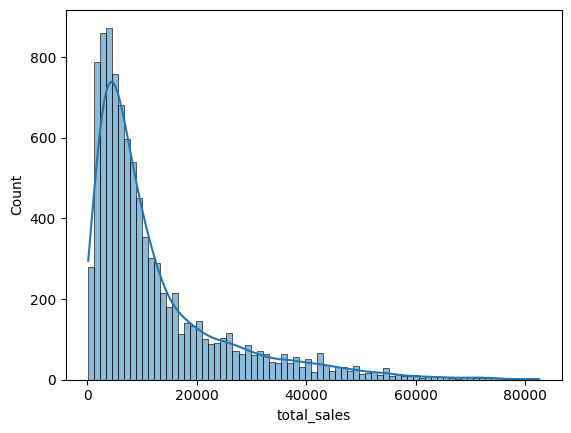

In [30]:
sns.histplot(df["total_sales"], kde = True)

<Axes: xlabel='total_sales'>

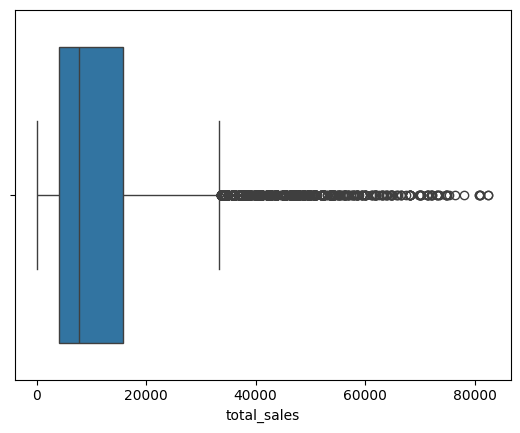

In [31]:
sns.boxplot(x=df["total_sales"])

- It is good that before we start to dig deeper, we look at the type of target we have. There is an asymmetric distribution because there will be many shops that have low or moderate levels. Few shops achieve high turnover or rarely achieve high turnover.

- Our model may be affected by this asymmetric distribution, so we need to do a logarithmic or box-cox transformation later.

---------

Creation of datasets by retailer

In [32]:
df["retailer"].value_counts()

retailer
Foot Locker      2630
West Gear        2372
Sports Direct    2030
Kohl's           1030
Amazon            949
Walmart           626
Name: count, dtype: int64

In [33]:
df_footlocker = df[df["retailer"] == "Foot Locker"]
df_westgear = df[df["retailer"] == "West Gear"]
df_sportsdirect = df[df["retailer"] == "Sports Direct"]
df_kohls = df[df["retailer"] == "Kohl's"]
df_amazon = df[df["retailer"] == "Amazon"]
df_walmart = df[df["retailer"] == "Walmart"]

In [ ]:
# We comment the code so as not to run it again, but this would be the cleaned dataset
df.to_csv("../data/adidas_sales_cleaned_last4.csv", index=False)

In [35]:
print("---Foot Locker---")
print(df_footlocker["total_sales"].describe())
print("---West Gear---")
print(df_westgear["total_sales"].describe())
print("---Sports Direct---")
print(df_sportsdirect["total_sales"].describe())
print("---Kohl's---")
print(df_kohls["total_sales"].describe())
print("---Amazon---")
print(df_amazon["total_sales"].describe())
print("---Walmart---")
print(df_walmart["total_sales"].describe())


---Foot Locker---
count     2630.000000
mean     11028.496198
std      12328.590997
min        160.000000
25%       3185.250000
50%       6689.500000
75%      13500.000000
max      76500.000000
Name: total_sales, dtype: float64
---West Gear---
count     2372.000000
mean     13624.708263
std      14074.800399
min        203.000000
25%       4263.750000
50%       8537.000000
75%      16855.500000
max      82500.000000
Name: total_sales, dtype: float64
---Sports Direct---
count     2030.000000
mean     12097.535468
std      11682.592391
min        528.000000
25%       4224.000000
50%       7522.000000
75%      15750.000000
max      69875.000000
Name: total_sales, dtype: float64
---Kohl's---
count     1030.000000
mean     13118.886408
std      11122.789865
min        520.000000
25%       5336.750000
50%       8243.000000
75%      20000.000000
max      52000.000000
Name: total_sales, dtype: float64
---Amazon---
count      949.000000
mean     10639.606955
std       9957.157975
min        416

# ✅ Step 4: Train and Test.


In [37]:
df_cleaned = pd.read_csv("../data/adidas_sales_cleaned_last4.csv", parse_dates=["invoice_date"], index_col=False)

In [38]:
df_cleaned

,retailer,invoice_date,region,state,city,product,price_per_unit,units_sold,total_sales
0,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.0,275,20625.0
1,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.0,83,4399.0
2,Foot Locker,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.0,384,13056.0
3,Foot Locker,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,68.0,83,5644.0
4,Foot Locker,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.0,336,15792.0
...,...,...,...,...,...,...,...,...,...
9632,Foot Locker,2021-12-31,Northeast,Pennsylvania,Philadelphia,Men's Apparel,63.0,47,2961.0
9633,Amazon,2021-12-31,Northeast,Maine,Portland,Men's Apparel,55.0,125,6875.0
9634,Foot Locker,2021-12-31,Northeast,Pennsylvania,Philadelphia,Men's Apparel,46.0,56,2576.0
9635,Amazon,2021-12-31,Northeast,Maine,Portland,Men's Apparel,52.0,36,1872.0


In [39]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9637 entries, 0 to 9636
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   retailer        9637 non-null   object        
 1   invoice_date    9637 non-null   datetime64[ns]
 2   region          9637 non-null   object        
 3   state           9637 non-null   object        
 4   city            9637 non-null   object        
 5   product         9637 non-null   object        
 6   price_per_unit  9637 non-null   float64       
 7   units_sold      9637 non-null   int64         
 8   total_sales     9637 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 677.7+ KB


A. PREDICTING THE BILLING OF DISTRIBUTING STORES 💵 (pt. I)

In [40]:
X = df_cleaned.drop(columns=["total_sales", "units_sold"])
y = df_cleaned["total_sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- We have removed the target and ***"units_sold ’*** from our **X** because we will not know the units sold. I have decided to leave ‘price_per_unit’ because we do know the price per unit.

----------------

# ✅ Step 5: Mini Eda + Dataset preparation


A. PREDICTING THE BILLING OF DISTRIBUTING STORES 💵 (pt. I)

In [41]:
X_train.columns

Index(['retailer', 'invoice_date', 'region', 'state', 'city', 'product',
       'price_per_unit'],
      dtype='object')

- We know the columns of **X_train**.
- We add some new columns like ***"month “*** and ***”day_of_week ’***.
- We remove non-relevant columns

In [42]:
X_train["month"] = X_train["invoice_date"].dt.month
X_train["day_of_week"] = X_train["invoice_date"].dt.dayofweek  # Monday=0, Sunday=6

X_test["month"] = X_test["invoice_date"].dt.month
X_test["day_of_week"] = X_test["invoice_date"].dt.dayofweek  # Monday=0, Sunday=6

In [43]:
X_train = X_train.drop(columns=["invoice_date", "city", "units_sold"], errors="ignore")
X_test = X_test.drop(columns=["invoice_date", "city", "units_sold"], errors="ignore")

In [44]:
X_train

,retailer,region,state,product,price_per_unit,month,day_of_week
485,West Gear,Southeast,Florida,Men's Apparel,60.0,4,4
6472,Sports Direct,South,Texas,Men's Apparel,26.0,8,6
1222,Foot Locker,Midwest,Minnesota,Men's Apparel,35.0,12,1
5608,West Gear,Northeast,New York,Women's Apparel,66.0,7,3
2855,Kohl's,Midwest,Montana,Women's Apparel,55.0,3,1
...,...,...,...,...,...,...,...
5734,Kohl's,Midwest,Kansas,Men's Athletic Footwear,49.0,7,0
5191,Sports Direct,Midwest,Michigan,Women's Street Footwear,41.0,6,3
5390,West Gear,West,Oregon,Men's Apparel,86.0,6,3
860,Walmart,South,Texas,Men's Apparel,45.0,8,6


- We want to make several **X_train**, in this case we are going to make a *Column Transform* so that our **XGBoost** and **Random Forest** models can work better.

In [45]:
categorical_features = ['retailer', 'region', 'state', 'product', 'day_of_week', "month"]
numeric_features = ['price_per_unit']

In [46]:
preprocessor = ColumnTransformer(
     transformers=[
      ("num", "passthrough", numeric_features),
      ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
ohe_columns_clean = np.char.replace(ohe_columns.astype(str), ' ', '_')
all_columns_clean = np.concatenate([numeric_features, ohe_columns_clean])

X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_columns_clean, index=X_train.index)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=all_columns_clean, index=X_test.index)

In [47]:
X_train_df

,price_per_unit,retailer_Amazon,retailer_Foot_Locker,retailer_Kohl's,retailer_Sports_Direct,retailer_Walmart,retailer_West_Gear,region_Midwest,region_Northeast,region_South,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
485,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6472,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1222,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5608,66.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2855,55.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,49.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5191,41.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,86.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


- We visualise our target in **y_train**.

In [48]:
y_train.describe()

count     7709.000000
mean     12378.403035
std      12626.345755
min        160.000000
25%       4080.000000
50%       7791.000000
75%      15750.000000
max      82500.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales'>

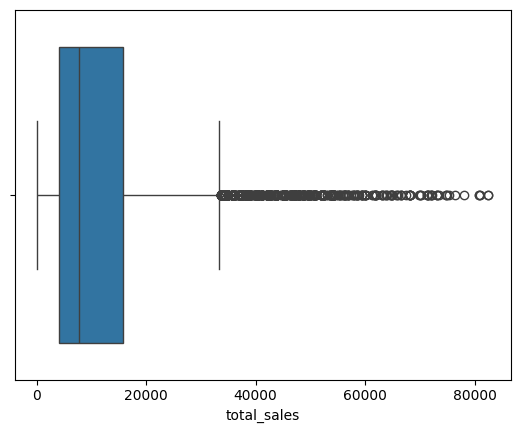

In [49]:
sns.boxplot(x=y_train)

<Axes: xlabel='total_sales', ylabel='Count'>

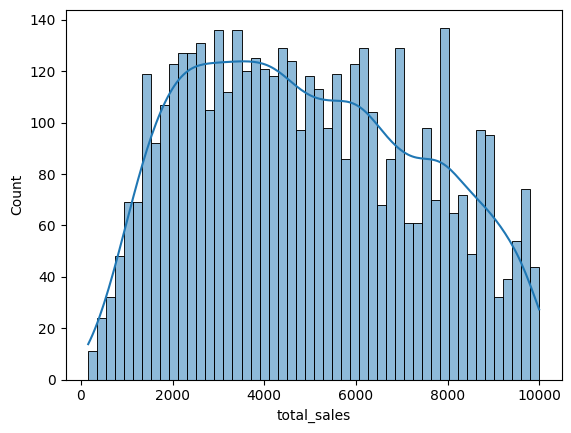

In [50]:
# Histplot from 0 to 10000
sns.histplot(y_train[y_train < 10000], bins=50, kde=True)

- I was visualising the values of my target. I realised that I had a lot of outliers. **Business** is important here, because my decision was to keep as much data as possible but I still tried every way.

-------------------

- I thought about imputing the median to the target so that I would have more concentrated values and not so dispersed. I had a long tail at the end and that could be bad for me.

In [54]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_no_outliers = y_train[(y_train >= lower_bound) & (y_train <= upper_bound)].median()
print(f"La mediana es de {median_no_outliers}")

y_train_imputed = y_train.copy()
y_train_imputed[(y_train < lower_bound) | (y_train > upper_bound)] = median_no_outliers

y_test_imputed = y_test.copy()
y_test_imputed[(y_test < lower_bound) | (y_test > upper_bound)] = median_no_outliers

La mediana es de 7000.0


In [55]:
y_train_imputed.describe()


count     7709.000000
mean      9265.476586
std       7304.726214
min        160.000000
25%       4080.000000
50%       7000.000000
75%      12000.000000
max      33250.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales', ylabel='Count'>

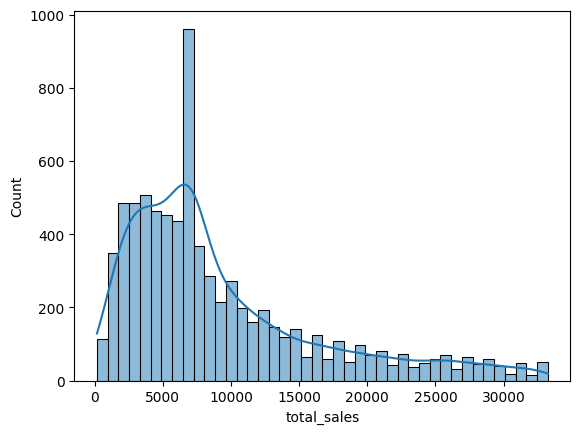

In [56]:
sns.histplot(y_train_imputed, kde = True)

- When I saw this, I thought it was a negative thing for any model. I don't want it to have excess values in an area that I have imputed myself.

🙋‍♂️ Option rejected

----------

- Capping / Windsorizing was my next proposal. 

In [57]:
upper_cap = y_train.quantile(0.95)
y_train_capped = y_train.copy()
y_train_capped[y_train_capped > upper_cap] = upper_cap

y_test_capped = y_test.copy()
y_test_capped[y_test_capped > upper_cap] = upper_cap

In [58]:
y_train_capped.describe()

count     7709.000000
mean     11829.161889
std      10853.102480
min        160.000000
25%       4080.000000
50%       7791.000000
75%      15750.000000
max      40450.000000
Name: total_sales, dtype: float64

<Axes: xlabel='total_sales', ylabel='Count'>

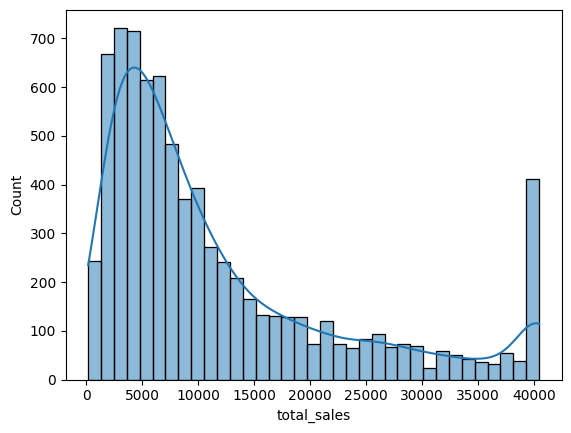

In [59]:
sns.histplot(y_train_capped, kde = True)

- I had good hopes for this method but it does something similar to the previous one. It generates a zone with a number of values imputed by me and that does not follow the nature of the graph.

🙋‍♂️ Option rejected

---------------

🔎 AFTER SO MANY TESTS:

I performed numerous tests, I thought that the values above 45k euros which are 260 rows and represented 3% of the dataset.... were the ones generating noise. But when I tested the model I could see that the improvement was very small and I didn't think it was necessary to lose information and then not improve significantly.

*You always have to have a real context and in the real environment these same decisions arise.*

BUSINESS MOMENT

- I think that the values that did make noise were the most extreme ones. Still, this would be something to discuss with team leaders.

In [60]:
# Remove extreme outliers
mask = (y_train >= 300) & (y_train <= 80000)

X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]

In [61]:
y_train_filtered.describe()

count     7697.000000
mean     12344.566065
std      12507.313632
min        320.000000
25%       4092.000000
50%       7791.000000
75%      15750.000000
max      78000.000000
Name: total_sales, dtype: float64

In [62]:
# Remove the outliers from the X_train_df where I had the Column Transform
X_train_df_mask = X_train_df[mask]

In [63]:
X_train_filtered

,retailer,region,state,product,price_per_unit,month,day_of_week
485,West Gear,Southeast,Florida,Men's Apparel,60.0,4,4
6472,Sports Direct,South,Texas,Men's Apparel,26.0,8,6
1222,Foot Locker,Midwest,Minnesota,Men's Apparel,35.0,12,1
5608,West Gear,Northeast,New York,Women's Apparel,66.0,7,3
2855,Kohl's,Midwest,Montana,Women's Apparel,55.0,3,1
...,...,...,...,...,...,...,...
5734,Kohl's,Midwest,Kansas,Men's Athletic Footwear,49.0,7,0
5191,Sports Direct,Midwest,Michigan,Women's Street Footwear,41.0,6,3
5390,West Gear,West,Oregon,Men's Apparel,86.0,6,3
860,Walmart,South,Texas,Men's Apparel,45.0,8,6


In [64]:
X_train_df_mask

,price_per_unit,retailer_Amazon,retailer_Foot_Locker,retailer_Kohl's,retailer_Sports_Direct,retailer_Walmart,retailer_West_Gear,region_Midwest,region_Northeast,region_South,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
485,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6472,26.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1222,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5608,66.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2855,55.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,49.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5191,41.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,86.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,45.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


- We have two training sets: **X_train_df_mask** (7697 x 87) and **X_train_filtered** (7697 x 7)

- To transform the target, I thought of a logarithmic but I read about Box-Cox and liked it better because it tried to make the data look as close as possible to a Gaussian distribution.

In [65]:
# box-cox transformation
y_train_boxcox, lambda_val = boxcox(y_train_filtered)

# lambda_val is the optimal parameter calculated for the transformation.
print(f"Lambda óptima: {lambda_val}")

Lambda óptima: 0.028619666115049194


In [66]:
# in test we apply the same boxcox as in train
y_test_boxcox = boxcox(y_test, lmbda=lambda_val)


<Axes: ylabel='Count'>

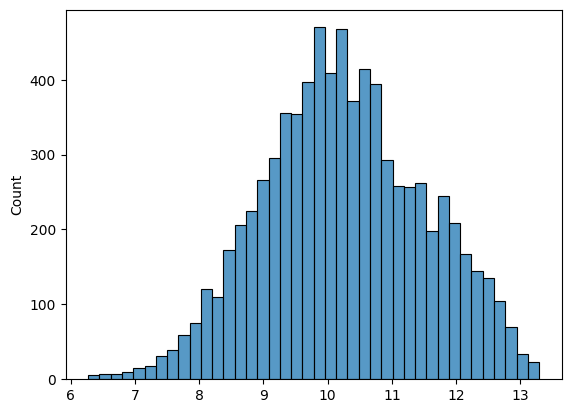

In [67]:
sns.histplot(y_train_boxcox)

- It does indeed look a lot better. We'll stick with the Box-Cox

- Here is an example of the logarithmic:

In [68]:
y_train_log = np.log1p(y_train_filtered)
y_test_log = np.log1p(y_test)

<Axes: xlabel='total_sales', ylabel='Count'>

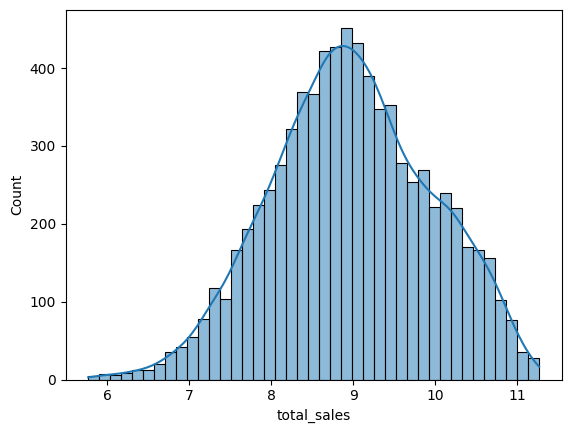

In [69]:
sns.histplot(y_train_log, kde = True)

- It was not a bad option at all but in a test I did the Box-Cox gave me a better result.

# ✅ Step 6: Model selection and instantiation. Baseline.


- We leave some loaded functions to be used in the following steps:

In [70]:
def rmse_boxcox_inverse(y_true_boxcox, y_pred_boxcox):
    y_true_original = inv_boxcox(y_true_boxcox, lambda_val)
    y_pred_original = inv_boxcox(y_pred_boxcox, lambda_val)
    
    return np.sqrt(mean_squared_error(y_true_original, y_pred_original))

scorer = make_scorer(rmse_boxcox_inverse, greater_is_better=False)

In [71]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer_tradi = make_scorer(rmse, greater_is_better=False)

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

**LINEAR REGRESSION**

In [73]:
# Training the linear regression model
baseline_lr = LinearRegression()

# Cross-validation scores
cv_rmse_scores_lr_baseline = []
cv_mae_scores_lr_baseline = []
cv_r2_scores_lr_baseline = []

# Manually to keep track of folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Create the model
    fold_model = baseline_lr
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_lr = fold_model.predict(X_val_fold)

    # Invert Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_lr, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calculate metrics
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_lr_baseline.append(rmse_fold)
    cv_mae_scores_lr_baseline.append(mae_fold)
    cv_r2_scores_lr_baseline.append(r2_fold)

print("\nCross-validation (Baseline LINEAR REGRESSION):")
print("RMSE por fold:", (cv_rmse_scores_lr_baseline))
print("MAE por fold:", (cv_mae_scores_lr_baseline))
print("R2 por fold:", (cv_r2_scores_lr_baseline))
print("RMSE Promedio:", np.mean(cv_rmse_scores_lr_baseline))
print("MAE Promedio:", np.mean(cv_mae_scores_lr_baseline))
print("R2 Promedio:", np.mean(cv_r2_scores_lr_baseline))


Cross-validation (Baseline LINEAR REGRESSION):
RMSE por fold: [9490.701291428159, 9806.525237720127, 10106.995422759615, 9102.039206207794, 9031.854564894737]
MAE por fold: [6325.768005273795, 6527.418274350297, 6821.144866960746, 6220.00708918769, 6214.420534459016]
R2 por fold: [0.44240673915692963, 0.37200331862620295, 0.3663832595266193, 0.4244890641574931, 0.4957168785782796]
RMSE Promedio: 9507.623144602087
MAE Promedio: 6421.751754046309
R2 Promedio: 0.4201998520091049


- I had a result with quite a lot of error and wanted to continue testing other models.

**MLP REGRESSOR**

In [74]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Entrenar el modelo de red neuronal
nn_model = MLPRegressor(random_state=42)

# Scores de validación cruzada
cv_rmse_scores_nn_baseline = []
cv_mae_scores_nn_baseline = []
cv_r2_scores_nn_baseline = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = nn_model
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_nn = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_nn, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_nn_baseline.append(rmse_fold)
    cv_mae_scores_nn_baseline.append(mae_fold)
    cv_r2_scores_nn_baseline.append(r2_fold)

print("\nValidación Cruzada (Baseline NEURAL NETWORK):")
print("RMSE por fold:", (cv_rmse_scores_nn_baseline))
print("MAE por fold:", (cv_mae_scores_nn_baseline))
print("R2 por fold:", (cv_r2_scores_nn_baseline))
print("RMSE Promedio:", np.mean(cv_rmse_scores_nn_baseline))
print("MAE Promedio:", np.mean(cv_mae_scores_nn_baseline))
print("R2 Promedio:", np.mean(cv_r2_scores_nn_baseline))



Validación Cruzada (Baseline NEURAL NETWORK):
RMSE por fold: [9563.135339407509, 9465.006536450637, 9534.006070715668, 8844.054455680225, 9182.596666413616]
MAE por fold: [6494.966237613399, 6713.205217085639, 6837.557680745695, 6365.685285568549, 6483.743283330764]
R2 por fold: [0.43386303699085815, 0.41498246382522985, 0.43618924862784014, 0.45665084901130104, 0.4787433858892288]
RMSE Promedio: 9317.759813733532
MAE Promedio: 6579.031540868808
R2 Promedio: 0.4440857968688916


- The result is very similar to the previous one, but falls far short of expectations.

**CATBOOST**

Our train here is **X_train_filtered** which contains 7 columns. **CatBoost** is a good model when we have categorical features.

In [75]:
# Construir el modelo
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# Scores de validación cruzada
cv_rmse_scores_cat_baseline = []
cv_mae_scores_cat_baseline = []
cv_r2_scores_cat_baseline = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_filtered):
    X_train_fold = X_train_filtered.iloc[train_index]
    X_val_fold = X_train_filtered.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = cat_model
    fold_model.fit(X_train_fold, y_train_fold, cat_features=categorical_features)

    # Predit Box Cox
    y_val_pred_boxcox_cat = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_cat, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_cat_baseline.append(rmse_fold)
    cv_mae_scores_cat_baseline.append(mae_fold)
    cv_r2_scores_cat_baseline.append(r2_fold)

print("\nValidación Cruzada (Baseline CATBOOST):")
print("RMSE por fold:", (cv_rmse_scores_cat_baseline))
print("MAE por fold:", (cv_mae_scores_cat_baseline))
print("R2 por fold:", (cv_r2_scores_cat_baseline))
print("RMSE Promedio:", np.mean(cv_rmse_scores_cat_baseline))
print("MAE Promedio:", np.mean(cv_mae_scores_cat_baseline))
print("R2 Promedio:", np.mean(cv_r2_scores_cat_baseline))


Validación Cruzada (Baseline CATBOOST):
RMSE por fold: [5712.441671010984, 5497.454683952111, 5936.052155155879, 5649.039600027918, 5480.557270504938]
MAE por fold: [3300.3806788800234, 3179.210826379288, 3529.7023001073667, 3233.7828572265385, 3278.9536261208914]
R2 por fold: [0.797993909382689, 0.8026439863964582, 0.7814363568614278, 0.7783205602819568, 0.8143179160675793]
RMSE Promedio: 5655.109076130366
MAE Promedio: 3304.4060577428218
R2 Promedio: 0.7949425457980223


🧠 GOOD to go forward with this model.

**RANDOM FOREST**

- Here we have **X_train_df_mask** contains 87 columns because it had the OneHotEncoder of our Column Transform.

In [76]:
# Construir el modelo
rf_model = RandomForestRegressor(random_state=42)

# Scores de validación cruzada
cv_rmse_scores_rf_baseline = []
cv_mae_scores_rf_baseline = []
cv_r2_scores_rf_baseline = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = rf_model
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_rf = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_rf, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_rf_baseline.append(rmse_fold)
    cv_mae_scores_rf_baseline.append(mae_fold)
    cv_r2_scores_rf_baseline.append(r2_fold)

print("\nValidación Cruzada (Baseline RF):")
print("RMSE por fold:", (cv_rmse_scores_rf_baseline))
print("MAE por fold:", (cv_mae_scores_rf_baseline))
print("R2 por fold:", (cv_r2_scores_rf_baseline))
print("RMSE Promedio:", np.mean(cv_rmse_scores_rf_baseline))
print("MAE Promedio:", np.mean(cv_mae_scores_rf_baseline))
print("R2 Promedio:", np.mean(cv_r2_scores_rf_baseline))


Validación Cruzada (Baseline RF):
RMSE por fold: [6967.818701101362, 6035.852254890726, 6743.0224662859655, 6216.350294189921, 6013.949257765285]
MAE por fold: [3712.7204882661217, 3447.3570656253296, 3828.2161770553207, 3437.919048032129, 3448.446404842048]
R2 por fold: [0.6994514819855915, 0.7620946277040466, 0.7179723307575232, 0.7315600587288726, 0.7764163304206954]
RMSE Promedio: 6395.3985948466525
MAE Promedio: 3574.93183676419
R2 Promedio: 0.7374989659193458


🧠 GOOD to go forward with this model.

**XGBOOST**

- Here we have **X_train_df_mask** contains 87 columns because it had the OneHotEncoder of our Column Transform.

In [77]:
# Entrenar el modelo XGBoost
xgb_model = XGBRegressor(random_state=42)

# Scores de validación cruzada
cv_rmse_scores_xgb_baseline = []
cv_mae_scores_xgb_baseline = []
cv_r2_scores_xgb_baseline = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = xgb_model
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_xgb = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_xgb, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_xgb_baseline.append(rmse_fold)
    cv_mae_scores_xgb_baseline.append(mae_fold)
    cv_r2_scores_xgb_baseline.append(r2_fold)

print("\nValidación Cruzada (Baseline XGBoost):")
print("RMSE por fold:", (cv_rmse_scores_xgb_baseline))
print("MAE por fold:", (cv_mae_scores_xgb_baseline))
print("R2 por fold:", (cv_r2_scores_xgb_baseline))
print("RMSE Promedio:", np.mean(cv_rmse_scores_xgb_baseline))
print("MAE Promedio:", np.mean(cv_mae_scores_xgb_baseline))
print("R2 Promedio:", np.mean(cv_r2_scores_xgb_baseline))


Validación Cruzada (Baseline XGBoost):
RMSE por fold: [6084.825527060639, 5573.785834855297, 6188.660126599135, 5962.432215378943, 5642.104618366732]
MAE por fold: [3331.660552304752, 3203.5689923274062, 3529.2728994864015, 3283.88728456454, 3192.313886636259]
R2 por fold: [0.7707986523756917, 0.7971254343298141, 0.7624386580596149, 0.7530420074273938, 0.8032100885098392]
RMSE Promedio: 5890.361664452149
MAE Promedio: 3308.1407230638715
R2 Promedio: 0.7773229681404707


🧠 GOOD to go forward with this model.

# ✅ Step 7: Model Comparison - Hyperparameters.


In [78]:
resultados_basics = pd.DataFrame({
    "Modelo": [
        "Linear Regression",
        "MLP Regression",
        "CatBoost",
        "Random Forest",
        "XGBoost",
    ],
    "RMSE Promedio": [
        np.mean(cv_rmse_scores_lr_baseline),
        np.mean(cv_rmse_scores_nn_baseline),
        np.mean(cv_rmse_scores_cat_baseline),
        np.mean(cv_rmse_scores_rf_baseline),
        np.mean(cv_rmse_scores_xgb_baseline)
    ],
    "MAE Promedio": [
        np.mean(cv_mae_scores_lr_baseline),
        np.mean(cv_mae_scores_nn_baseline),
        np.mean(cv_mae_scores_cat_baseline),
        np.mean(cv_mae_scores_rf_baseline),
        np.mean(cv_mae_scores_xgb_baseline)
    ],
    "R2 Promedio": [
        np.mean(cv_r2_scores_lr_baseline),
        np.mean(cv_r2_scores_nn_baseline),
        np.mean(cv_r2_scores_cat_baseline),
        np.mean(cv_r2_scores_rf_baseline),
        np.mean(cv_r2_scores_xgb_baseline)
    ]
})

resultados_basics[["RMSE Promedio", "MAE Promedio", "R2 Promedio"]] = resultados_basics[["RMSE Promedio", "MAE Promedio", "R2 Promedio"]].round(3)

# Vista rápida de la tabla
print(resultados_basics)


              Modelo  RMSE Promedio  MAE Promedio  R2 Promedio
0  Linear Regression       9507.623      6421.752        0.420
1     MLP Regression       9317.760      6579.032        0.444
2           CatBoost       5655.109      3304.406        0.795
3      Random Forest       6395.399      3574.932        0.737
4            XGBoost       5890.362      3308.141        0.777


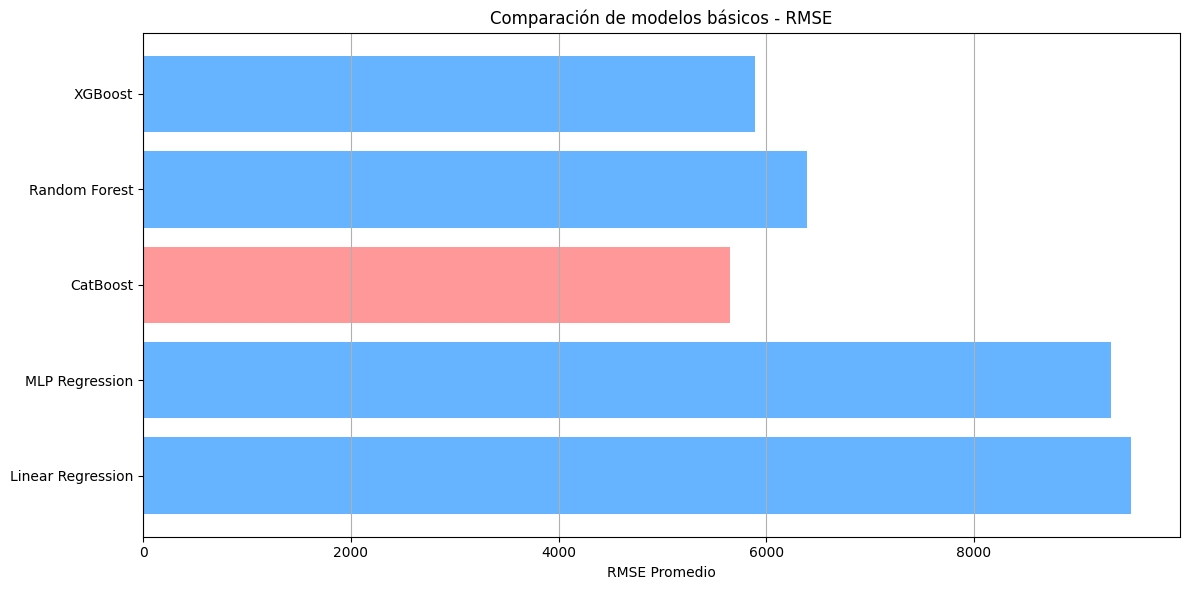

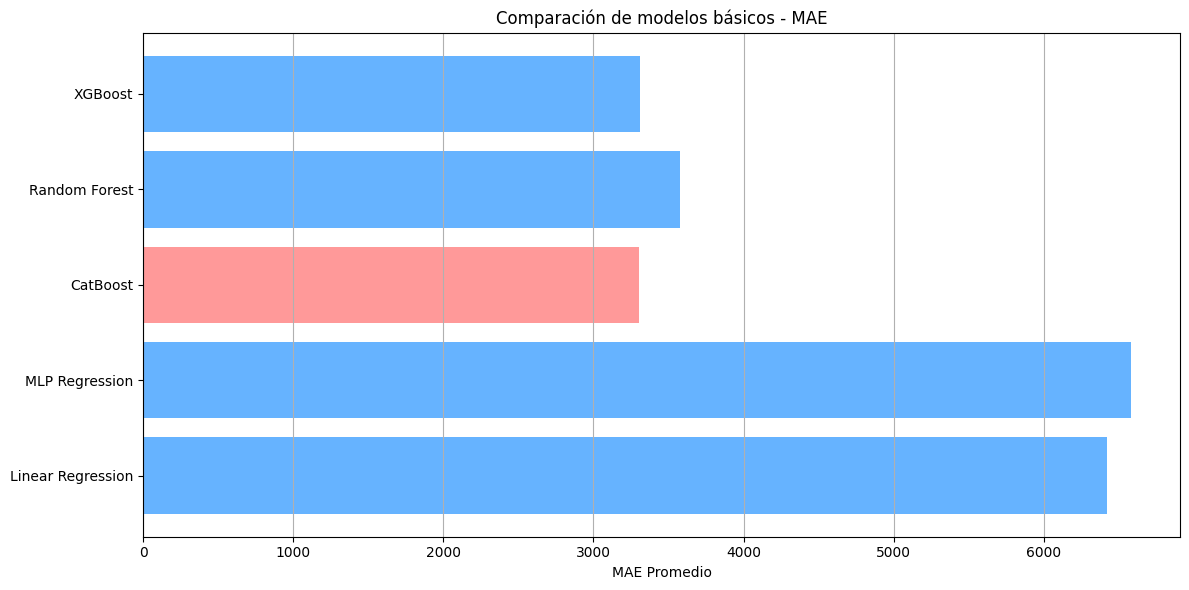

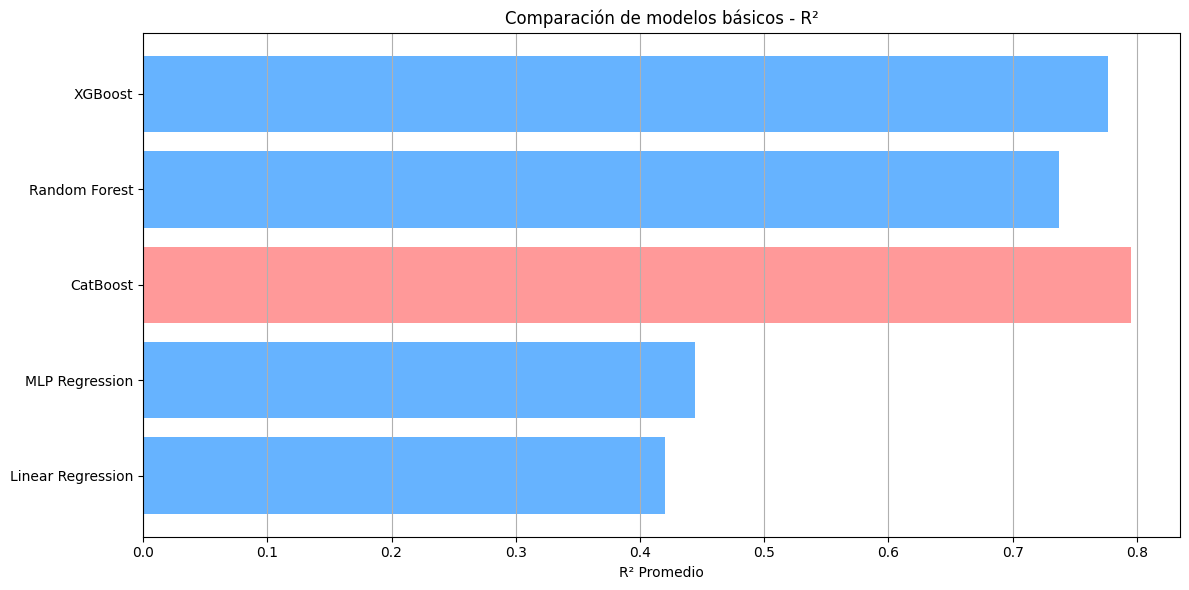

In [79]:
# Pintamos para ver los resultados
best_rmse_idx = resultados_basics["RMSE Promedio"].idxmin()
best_mae_idx = resultados_basics["MAE Promedio"].idxmin()
best_r2_idx = resultados_basics["R2 Promedio"].idxmax()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_rmse_idx else '#66B3FF' for i in range(len(resultados_basics))]
plt.barh(resultados_basics["Modelo"], resultados_basics["RMSE Promedio"], color=colors)
plt.xlabel("RMSE Promedio")
plt.title("Comparación de modelos básicos - RMSE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_mae_idx else '#66B3FF' for i in range(len(resultados_basics))]
plt.barh(resultados_basics["Modelo"], resultados_basics["MAE Promedio"], color=colors)
plt.xlabel("MAE Promedio")
plt.title("Comparación de modelos básicos - MAE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_r2_idx else '#66B3FF' for i in range(len(resultados_basics))]
plt.barh(resultados_basics["Modelo"], resultados_basics["R2 Promedio"], color=colors)
plt.xlabel("R² Promedio")
plt.title("Comparación de modelos básicos - R²")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

- Looking at the comparison. It looks like **CATBOOST** was the best baseline-basic model. **XGBOOST** has great potential and **RF** is a bit behind but we will give it a try.

---------

- Search for hyperparameters **GRIDSEARCH** and **RANDOMIZEDSEARCH**.

**CATBOOST**

In [80]:
# CATBOOST GRIDSEARCH

param_grid = {
    "depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
    "iterations": [300, 500, 700],
    "l2_leaf_reg": [1, 3, 5]
}

grid_cat = GridSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1
)

grid_cat.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

best_model_cat = grid_cat.best_estimator_

# Mejores hiperparametros
print(f"Mejores hiperparametros: {grid_cat.best_params_}")
print(f"Mejor score RMSE: {-grid_cat.best_score_}")

Mejores hiperparametros: {'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.5}
Mejor score RMSE: 5472.713596670264


We have obtained for **CATBOOST** the hyperparameters of our GridSearch. It looks like the model has improved. Let's collect these hyperparameters and reuse the code to see the cross validation in detail:

In [81]:
# Scores de validacion cruzada despues del GridSearch CATBOOST
cv_rmse_scores_cat_grid = []
cv_mae_scores_cat_grid = []
cv_r2_scores_cat_grid = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_filtered):
    X_train_fold = X_train_filtered.iloc[train_index]
    X_val_fold = X_train_filtered.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = best_model_cat # Usar el mejor modelo encontrado en el GridSearch
    fold_model.fit(X_train_fold, y_train_fold, cat_features=categorical_features)

    # Predit Box Cox
    y_val_pred_boxcox_cat_grid = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_cat_grid, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_cat_grid.append(rmse_fold)
    cv_mae_scores_cat_grid.append(mae_fold)
    cv_r2_scores_cat_grid.append(r2_fold)

print("\nValidación Cruzada (GRIDSEARCH CATBOOST):")
print("RMSE por fold:", (cv_rmse_scores_cat_grid))
print("MAE por fold:", (cv_mae_scores_cat_grid))
print("R2 por fold:", (cv_r2_scores_cat_grid))
print("RMSE Promedio:", np.mean(cv_rmse_scores_cat_grid))
print("MAE Promedio:", np.mean(cv_mae_scores_cat_grid))
print("R2 Promedio:", np.mean(cv_r2_scores_cat_grid))


Validación Cruzada (GRIDSEARCH CATBOOST):
RMSE por fold: [5788.8694795577585, 5413.8676697803, 5743.834775200887, 5449.391118928253, 5311.018815527692]
MAE por fold: [3247.690047292906, 3080.5296506169325, 3438.981820168298, 3134.5497556187424, 3170.417505647456]
R2 por fold: [0.7925523964389998, 0.8085998294707365, 0.7953619530273177, 0.7937128689054365, 0.825628203943759]
RMSE Promedio: 5541.396371798978
MAE Promedio: 3214.4337558688667
R2 Promedio: 0.8031710503572498


In [82]:
# CATBOOST RANDOMIZEDSEARCH
param_dist_cat = {
    "depth": [3,4,5,6,7],
    "learning_rate": [0.01, 0.05, 0.1, 0.3, 0.5],
    "iterations": [300, 500,700, 1000],
    "l2_leaf_reg": [1, 3, 5, 7]
}

random_search = RandomizedSearchCV(
    estimator=CatBoostRegressor(verbose=0, random_state=42),
    param_distributions=param_dist_cat,
    n_iter=30,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

best_model_random_cat = random_search.best_estimator_

# Mejores hiperparámetros
print(f"Mejores hiperparametros: {random_search.best_params_}")
print(f"Mejor score RMSE: {-random_search.best_score_}")

Mejores hiperparametros: {'learning_rate': 0.3, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6}
Mejor score RMSE: 5512.113412613679


It seems that the **CATBOOST** model is better with the hyperparameters in GridSearch (RMSE 5472). Let's check these RandomizedSearch hyperparameters with a cross-validation:

In [83]:
# Scores de validacion cruzada despues del RandomizedSearch CATBOOST
cv_rmse_scores_cat_random = []
cv_mae_scores_cat_random = []
cv_r2_scores_cat_random = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_filtered):
    X_train_fold = X_train_filtered.iloc[train_index]
    X_val_fold = X_train_filtered.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = best_model_random_cat # Usar el mejor modelo encontrado en el RandomizedSearch
    fold_model.fit(X_train_fold, y_train_fold, cat_features=categorical_features)

    # Predit Box Cox
    y_val_pred_boxcox_cat_random = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_cat_random, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_cat_random.append(rmse_fold)
    cv_mae_scores_cat_random.append(mae_fold)
    cv_r2_scores_cat_random.append(r2_fold)

print("\nValidación Cruzada (RANDOMIZEDSEARCH CATBOOST):")
print("RMSE por fold:", (cv_rmse_scores_cat_random))
print("MAE por fold:", (cv_mae_scores_cat_random))
print("R2 por fold:", (cv_r2_scores_cat_random))
print("RMSE Promedio:", np.mean(cv_rmse_scores_cat_random))
print("MAE Promedio:", np.mean(cv_mae_scores_cat_random))
print("R2 Promedio:", np.mean(cv_r2_scores_cat_random))


Validación Cruzada (RANDOMIZEDSEARCH CATBOOST):
RMSE por fold: [5729.847491559282, 5523.102028262718, 5792.255329998656, 5586.90433827296, 5453.567345432827]
MAE por fold: [3205.0174839476085, 3105.37679673969, 3390.7379399801553, 3127.1587688689406, 3228.601506210273]
R2 por fold: [0.7967610080351966, 0.8007982359421983, 0.7918972109867242, 0.7831703607669812, 0.816142258077648]
RMSE Promedio: 5617.135306705289
MAE Promedio: 3211.3784991493335
R2 Promedio: 0.7977538147617496


⭐ Exactly, our **CATBOOST** is better with the hyperparameters in **GRIDSEARCH**.

**RANDOM FOREST**

In [84]:
# RF GRIDSEARCH

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_df_mask, y_train_boxcox)
best_model_rf = grid_search.best_estimator_

# Mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor score RMSE: {-grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor score RMSE: 6208.17


In [85]:
# Scores de validacion cruzada despues del GridSearch RF
cv_rmse_scores_rf_grid = []
cv_mae_scores_rf_grid = []
cv_r2_scores_rf_grid = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = best_model_rf # Usar el mejor modelo encontrado en el GridSearch
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_rf_grid = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_rf_grid, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_rf_grid.append(rmse_fold)
    cv_mae_scores_rf_grid.append(mae_fold)
    cv_r2_scores_rf_grid.append(r2_fold)

print("\nValidación Cruzada (GRIDSEARCH RF):")
print("RMSE por fold:", (cv_rmse_scores_rf_grid))
print("MAE por fold:", (cv_mae_scores_rf_grid))
print("R2 por fold:", (cv_r2_scores_rf_grid))
print("RMSE Promedio:", np.mean(cv_rmse_scores_rf_grid))
print("MAE Promedio:", np.mean(cv_mae_scores_rf_grid))
print("R2 Promedio:", np.mean(cv_r2_scores_rf_grid))


Validación Cruzada (GRIDSEARCH RF):
RMSE por fold: [6924.377130655238, 6042.920367026969, 6667.413777329697, 6192.208157542981, 6054.4682525602975]
MAE por fold: [3689.3333772776964, 3437.112165375206, 3784.7022185487185, 3422.1162148114427, 3465.867117638873]
R2 por fold: [0.7031873998577014, 0.76153711690395, 0.7242615555569862, 0.7336410641489386, 0.7733933902633476]
RMSE Promedio: 6376.2775370230365
MAE Promedio: 3559.826218730387
R2 Promedio: 0.7392041053461847


In [86]:
# RF RandomizedSearch

param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train_df_mask, y_train_boxcox)
best_model_rf_random = random_search_rf.best_estimator_
best_params_rf_random = random_search_rf.best_params_
print(f"Mejores hiperparámetros RF (RandomizedSearch): {best_params_rf_random}")
print(f"Mejor score RMSE RF (RandomizedSearch): {-random_search_rf.best_score_:.2f}")

Mejores hiperparámetros RF (RandomizedSearch): {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Mejor score RMSE RF (RandomizedSearch): 6210.70


Results from **RANDOM FOREST** are a bit poor. We will not CV the hyperparameters obtained from your RandomizedSearch because it is not interesting to advance with this model. We will probably leave it aside for the next phase.

**XGBOOST**

In [87]:
# XGBOOST GRIDSEARCH

param_grid = {
    'n_estimators': [100, 150, 200, 300],
    'learning_rate': [0.01, 0.10, 0.25, 0.30],
    'max_depth': [4, 5, 6, 7]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator= XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scorer,
    n_jobs=-1
)
grid_search.fit(X_train_df_mask, y_train_boxcox)

best_model_xgb = grid_search.best_estimator_

# Mejores hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor score RMSE: {-grid_search.best_score_:.2f}")

Mejores hiperparámetros: {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 300}
Mejor score RMSE: 5386.97


In [88]:
# Scores de validacion cruzada despues del GridSearch XGBOOST
cv_rmse_scores_xgb_grid = []
cv_mae_scores_xgb_grid = []
cv_r2_scores_xgb_grid = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = best_model_xgb # Usar el mejor modelo encontrado en el GridSearch
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_xgb_grid = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_xgb_grid, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_xgb_grid.append(rmse_fold)
    cv_mae_scores_xgb_grid.append(mae_fold)
    cv_r2_scores_xgb_grid.append(r2_fold)

print("\nValidación Cruzada (GRIDSEARCH XGBOOST):")
print("RMSE por fold:", (cv_rmse_scores_xgb_grid))
print("MAE por fold:", (cv_mae_scores_xgb_grid))
print("R2 por fold:", (cv_r2_scores_xgb_grid))
print("RMSE Promedio:", np.mean(cv_rmse_scores_xgb_grid))
print("MAE Promedio:", np.mean(cv_mae_scores_xgb_grid))
print("R2 Promedio:", np.mean(cv_r2_scores_xgb_grid))


Validación Cruzada (GRIDSEARCH XGBOOST):
RMSE por fold: [5915.672579398177, 5354.872204181995, 5824.9451787302705, 5546.181841584083, 5279.5780069141065]
MAE por fold: [3211.8528435050684, 3062.7600227653206, 3308.7928938342056, 3144.201076653813, 3013.756083091255]
R2 por fold: [0.7833647303346644, 0.8127485154861913, 0.7895416361784529, 0.7863197485926721, 0.8276866273085743]
RMSE Promedio: 5584.249962161726
MAE Promedio: 3148.2725839699324
R2 Promedio: 0.7999322515801109


In [89]:
# XGBOOST RANDOMIZEDSEARCH

param_dist_xgb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.15, 0.3],
    'max_depth': [4, 5, 6, 7]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=30,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_df_mask, y_train_boxcox)

best_model_xgb_random = random_search_xgb.best_estimator_
best_params_xgb_random = random_search_xgb.best_params_

print(f"Mejores hiperparámetros XGBoost (RandomizedSearch): {best_params_xgb_random}")
print(f"Mejor score RMSE XGBoost (RandomizedSearch): {-random_search_xgb.best_score_:.2f}")

Mejores hiperparámetros XGBoost (RandomizedSearch): {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.3}
Mejor score RMSE XGBoost (RandomizedSearch): 5446.50


In [90]:
# Scores de validacion cruzada despues del RandomizedSearch XGBOOST
cv_rmse_scores_xgb_random = []
cv_mae_scores_xgb_random = []
cv_r2_scores_xgb_random = []

# De forma manual para no perder el control de los folds
for train_index, val_index in kf.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = best_model_xgb_random # Usar el mejor modelo encontrado en el RandomizedSearch
    fold_model.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_xgb_random = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_xgb_random, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores_xgb_random.append(rmse_fold)
    cv_mae_scores_xgb_random.append(mae_fold)
    cv_r2_scores_xgb_random.append(r2_fold)

print("\nValidación Cruzada (RANDOMIZEDSEARCH XGBOOST):")
print("RMSE por fold:", (cv_rmse_scores_xgb_random))
print("MAE por fold:", (cv_mae_scores_xgb_random))
print("R2 por fold:", (cv_r2_scores_xgb_random))
print("RMSE Promedio:", np.mean(cv_rmse_scores_xgb_random))
print("MAE Promedio:", np.mean(cv_mae_scores_xgb_random))
print("R2 Promedio:", np.mean(cv_r2_scores_xgb_random))


Validación Cruzada (RANDOMIZEDSEARCH XGBOOST):
RMSE por fold: [5756.451751279859, 5455.834085496214, 5902.056861224635, 5507.761014542338, 5348.041313818823]
MAE por fold: [3125.221829976665, 3082.0921251569475, 3331.2423002901146, 3082.194626875712, 3038.749815665103]
R2 por fold: [0.7948693082606664, 0.8056209937405672, 0.7839325813565976, 0.7892700073021258, 0.8231886793838169]
RMSE Promedio: 5594.029005272374
MAE Promedio: 3131.9001395929085
R2 Promedio: 0.7993763140087548


In [91]:
resultados_hiperparametros = pd.DataFrame({
    "Modelos": [
        "CatBoost GridSearch CV",
        "Xboost GridSearch CV"
    ],
    "RMSE Promedio": [
        np.mean(cv_rmse_scores_cat_grid),
        np.mean(cv_rmse_scores_xgb_grid)
    ],
    "MAE Promedio": [
        np.mean(cv_mae_scores_cat_grid),
        np.mean(cv_mae_scores_xgb_grid)
    ],
    "R2 Promedio": [
        np.mean(cv_r2_scores_cat_grid),
        np.mean(cv_r2_scores_xgb_grid)
    ]
})


# Redondeamos
resultados_hiperparametros[["RMSE Promedio", "MAE Promedio", "R2 Promedio"]] = resultados_hiperparametros[["RMSE Promedio", "MAE Promedio", "R2 Promedio"]].round(3)
# Vista rápida de la tabla
print(resultados_hiperparametros)

                  Modelos  RMSE Promedio  MAE Promedio  R2 Promedio
0  CatBoost GridSearch CV       5541.396      3214.434        0.803
1    Xboost GridSearch CV       5584.250      3148.273        0.800


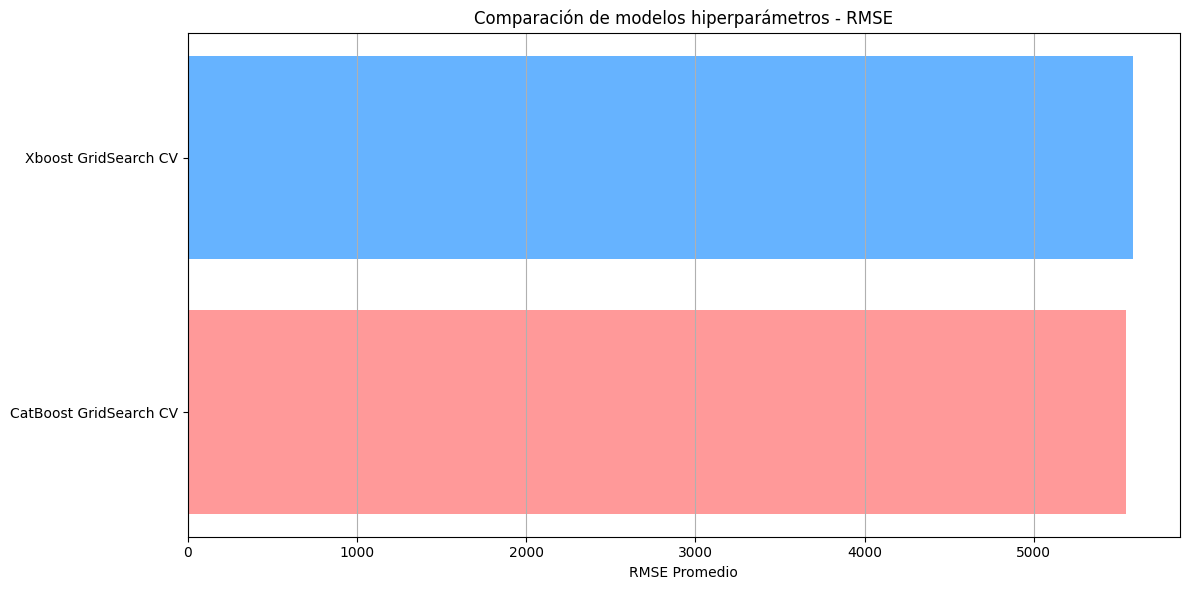

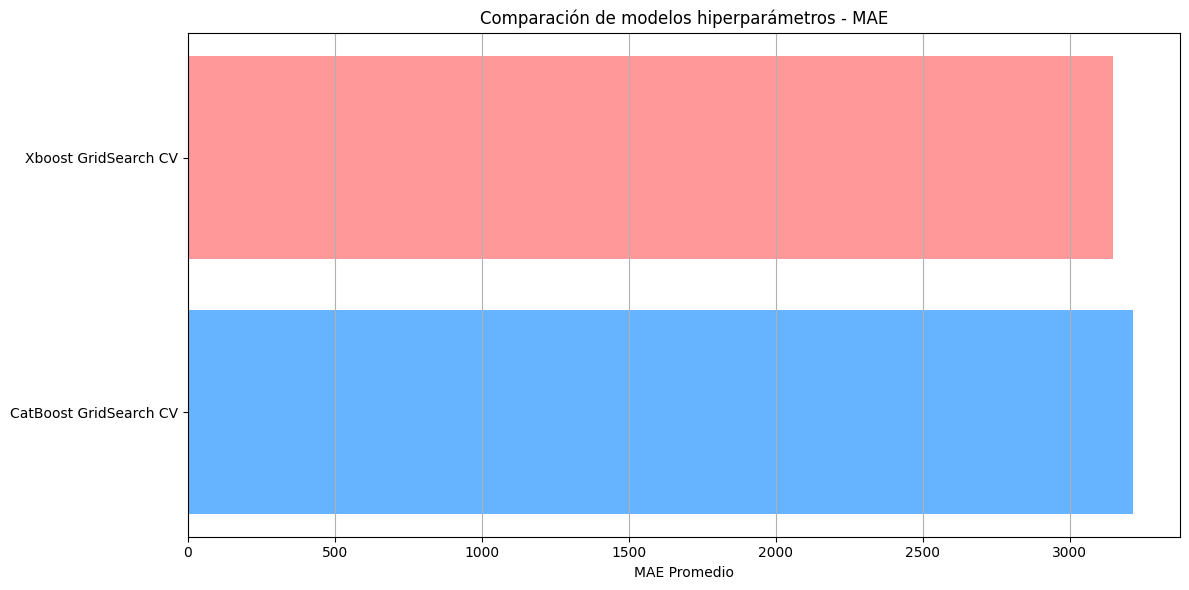

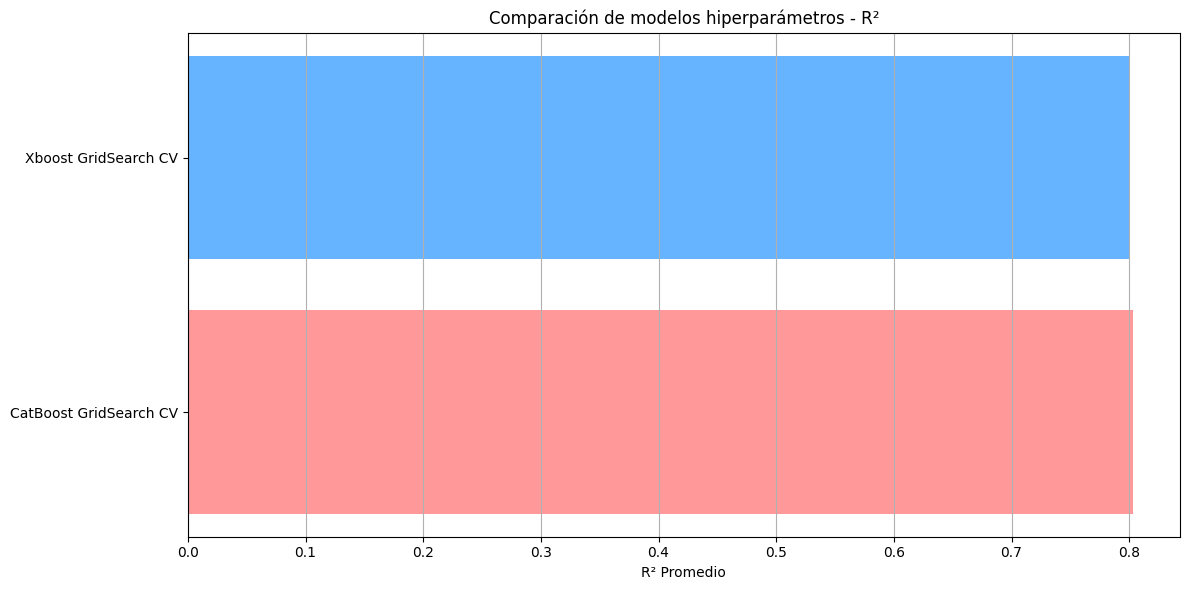

In [92]:
# Pintamos para ver los resultados

best_rmse_idx_hiper = resultados_hiperparametros["RMSE Promedio"].idxmin()
best_mae_idx_hiper = resultados_hiperparametros["MAE Promedio"].idxmin()
best_r2_idx_hiper = resultados_hiperparametros["R2 Promedio"].idxmax()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_rmse_idx_hiper else '#66B3FF' for i in range(len(resultados_hiperparametros))]
plt.barh(resultados_hiperparametros["Modelos"], resultados_hiperparametros["RMSE Promedio"], color=colors)
plt.xlabel("RMSE Promedio")
plt.title("Comparación de modelos hiperparámetros - RMSE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_mae_idx_hiper else '#66B3FF' for i in range(len(resultados_hiperparametros))]
plt.barh(resultados_hiperparametros["Modelos"], resultados_hiperparametros["MAE Promedio"], color=colors)
plt.xlabel("MAE Promedio")
plt.title("Comparación de modelos hiperparámetros - MAE")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
colors = ['#FF9999' if i == best_r2_idx_hiper else '#66B3FF' for i in range(len(resultados_hiperparametros))]
plt.barh(resultados_hiperparametros["Modelos"], resultados_hiperparametros["R2 Promedio"], color=colors)
plt.xlabel("R² Promedio")
plt.title("Comparación de modelos hiperparámetros - R²")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


- Seeing that our GridSearch in **CATBOOST** performed better, we will implement it in the model and evaluate it finally.
- **RANDOM FOREST** did not perform and will be discarded for the next step.
- **XGBOOST** is very interesting, fast and has improved on its baseline. We will use the hyperparameters of Gridsearch.

# ✅ Step 8: Final evaluation - CATBOOST vs XGBOOST.


--------

**CATBOOST - FINAL EVALUATION**

In [93]:
# Evaluacion final

#KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Entrenamos el modelo con los datos transformados
cat_model_final = CatBoostRegressor(depth= 3, iterations=500, l2_leaf_reg= 5, learning_rate=0.5, verbose=0, random_state=42)
cat_model_final.fit(X_train_filtered, y_train_boxcox, cat_features=categorical_features)

# Realizamos score en el conjunto de entrenamiento
score_cat_model = cat_model_final.score(X_train_filtered, y_train_boxcox)
print(f"Score CatBoost Inicial R2 (BoxCox no invertido): {score_cat_model:.4f}")

y_train_pred_boxcox_cat = cat_model_final.predict(X_train_filtered)

# Métricas en el espacio Box-Cox
train_rmse_boxcox = np.sqrt(mean_squared_error(y_train_boxcox, y_train_pred_boxcox_cat))
print(f"Entrenamiento (Box-Cox): RMSE = {train_rmse_boxcox:.2f}")

# Invertimos
y_train_pred_original = inv_boxcox(y_train_pred_boxcox_cat, lambda_val)
y_train_original = inv_boxcox(y_train_boxcox, lambda_val)

train_rmse = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
train_mae = mean_absolute_error(y_train_original, y_train_pred_original)
train_r2 = r2_score(y_train_original, y_train_pred_original)
print(f"Entrenamiento (Original): RMSE = {train_rmse:.2f}, MAE = {train_mae:.2f}, R2 = {train_r2:.4f}")

# Realizamos score en el conjunto de validación manualmente
# porque kfold al hacer split, no tiene en cuenta categorical_features
cv_rmse_scores = []
cv_mae_scores = []
cv_r2_scores = []
for train_index, val_index in kf.split(X_train_filtered):
    X_train_fold = X_train_filtered.iloc[train_index]
    X_val_fold = X_train_filtered.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model = CatBoostRegressor(depth= 3, iterations=500, l2_leaf_reg= 5, learning_rate=0.5, verbose=0, random_state=42)
    fold_model.fit(X_train_fold, y_train_fold, cat_features=categorical_features)

    # Predit Box Cox
    y_val_pred_boxcox_cat = fold_model.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original = inv_boxcox(y_val_pred_boxcox_cat, lambda_val)
    y_val_original = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
    mae_fold = mean_absolute_error(y_val_original, y_val_pred_original)
    r2_fold = r2_score(y_val_original, y_val_pred_original)

    cv_rmse_scores.append(rmse_fold)
    cv_mae_scores.append(mae_fold)
    cv_r2_scores.append(r2_fold)

print("\nValidación Cruzada (Original):")
print("RMSE por fold:", (cv_rmse_scores))
print("MAE por fold:", (cv_mae_scores))
print("R2 por fold:", (cv_r2_scores))
print("RMSE Promedio:", np.mean(cv_rmse_scores))
print("MAE Promedio:", np.mean(cv_mae_scores))
print("R2 Promedio:", np.mean(cv_r2_scores))

# Realizamos score en el conjunto de prueba
y_pred_boxcox_cat = cat_model_final.predict(X_test)
y_pred = inv_boxcox(y_pred_boxcox_cat, lambda_val)

mse_cat_test = mean_squared_error(y_test, y_pred)
rmse_cat_test = np.sqrt(mse_cat_test)
mae_cat_test = mean_absolute_error(y_test, y_pred)
r2_cat_test = r2_score(y_test, y_pred)

print("\nTest Set (Original):")
print(f"RMSE: {rmse_cat_test:2f}")
print(f"MAE: {mae_cat_test:2f}")
print(f"R2: {r2_cat_test:.4f}")

Score CatBoost Inicial R2 (BoxCox no invertido): 0.8629
Entrenamiento (Box-Cox): RMSE = 0.46
Entrenamiento (Original): RMSE = 5080.58, MAE = 3134.64, R2 = 0.8350

Validación Cruzada (Original):
RMSE por fold: [5788.8694795577585, 5413.8676697803, 5743.834775200887, 5449.391118928253, 5311.018815527692]
MAE por fold: [3247.690047292906, 3080.5296506169325, 3438.981820168298, 3134.5497556187424, 3170.417505647456]
R2 por fold: [0.7925523964389998, 0.8085998294707365, 0.7953619530273177, 0.7937128689054365, 0.825628203943759]
RMSE Promedio: 5541.396371798978
MAE Promedio: 3214.4337558688667
R2 Promedio: 0.8031710503572498

Test Set (Original):
RMSE: 5260.050513
MAE: 3136.047537
R2: 0.8369


**XGBOOST - FINAL EVALUATION**

In [94]:
# Evaluacion final

# Kfold
kf_xgb = KFold(n_splits=5, shuffle=True, random_state=42)

# Entrenamos el modelo con los datos transformados
xgb_model_final = XGBRegressor(learning_rate = 0.25, max_depth = 4, n_estimators = 300, verbose=0, random_state=42)
xgb_model_final.fit(X_train_df_mask, y_train_boxcox)

# Realizamos score en el conjunto de entrenamiento
score_xgb_model = xgb_model_final.score(X_train_df_mask, y_train_boxcox)
print(f"Score XGBoost Inicial R2 (BoxCox no invertido): {score_xgb_model:.4f}")

y_train_pred_boxcox_xgb = xgb_model_final.predict(X_train_df_mask)

# Métricas en el espacio Box-Cox
train_rmse_boxcox_xgb = np.sqrt(mean_squared_error(y_train_boxcox, y_train_pred_boxcox_xgb))
print(f"Entrenamiento (Box-Cox): RMSE = {train_rmse_boxcox_xgb:.2f}")

# Invertimos
y_train_pred_original_xgb = inv_boxcox(y_train_pred_boxcox_xgb, lambda_val)
y_train_original_xgb = inv_boxcox(y_train_boxcox, lambda_val)

train_rmse_xgb = np.sqrt(mean_squared_error(y_train_original_xgb, y_train_pred_original_xgb))
train_mae_xgb = mean_absolute_error(y_train_original_xgb, y_train_pred_original_xgb)
train_r2_xgb = r2_score(y_train_original_xgb, y_train_pred_original_xgb)
print(f"Entrenamiento (Original): RMSE = {train_rmse_xgb:.2f}, MAE = {train_mae_xgb:.2f}, R2 = {train_r2_xgb:.4f}")

# Realizamos score en el conjunto de validación manualmente
# simplemente por seguir la misma guia que en CATBOOST

cv_rmse_scores_xgb = []
cv_mae_scores_xgb = []
cv_r2_scores_xgb = []

for train_index, val_index in kf_xgb.split(X_train_df_mask):
    X_train_fold = X_train_df_mask.iloc[train_index]
    X_val_fold = X_train_df_mask.iloc[val_index]
    y_train_fold = y_train_boxcox[train_index]
    y_val_fold = y_train_boxcox[val_index]

    # Crear el modelo
    fold_model_xgb = XGBRegressor(learning_rate = 0.25, max_depth = 4, n_estimators = 300, verbosity=0, random_state=42)
    fold_model_xgb.fit(X_train_fold, y_train_fold)

    # Predit Box Cox
    y_val_pred_boxcox_xgb = fold_model_xgb.predict(X_val_fold)

    # Invertir Box-Cox
    y_val_pred_original_xgb = inv_boxcox(y_val_pred_boxcox_xgb, lambda_val)
    y_val_original_xgb = inv_boxcox(y_val_fold, lambda_val)

    # Calcular métricas
    rmse_fold_xgb = np.sqrt(mean_squared_error(y_val_original_xgb, y_val_pred_original_xgb))
    mae_fold_xgb = mean_absolute_error(y_val_original_xgb, y_val_pred_original_xgb)
    r2_fold_xgb = r2_score(y_val_original_xgb, y_val_pred_original_xgb)

    cv_rmse_scores_xgb.append(rmse_fold_xgb)
    cv_mae_scores_xgb.append(mae_fold_xgb)
    cv_r2_scores_xgb.append(r2_fold_xgb)

print("\nValidación Cruzada (Original):")
print("RMSE por fold:", (cv_rmse_scores_xgb))
print("MAE por fold:", (cv_mae_scores_xgb))
print("R2 por fold:", (cv_r2_scores_xgb))
print("RMSE Promedio:", np.mean(cv_rmse_scores_xgb))
print("MAE Promedio:", np.mean(cv_mae_scores_xgb))
print("R2 Promedio:", np.mean(cv_r2_scores_xgb))

# Realizamos score en el conjunto de prueba
y_pred_boxcox_xgb = xgb_model_final.predict(X_test_df)
y_pred_xgb = inv_boxcox(y_pred_boxcox_xgb, lambda_val)

mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb_test = np.sqrt(mse_xgb_test)
mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb_test = r2_score(y_test, y_pred_xgb)

print("\nTest Set (Original):")
print(f"RMSE: {rmse_xgb_test:.2f}")
print(f"MAE: {mae_xgb_test:.2f}")
print(f"R2: {r2_xgb_test:.4f}")


Score XGBoost Inicial R2 (BoxCox no invertido): 0.9121
Entrenamiento (Box-Cox): RMSE = 0.37
Entrenamiento (Original): RMSE = 3979.64, MAE = 2327.32, R2 = 0.8987

Validación Cruzada (Original):
RMSE por fold: [5915.672579398177, 5354.872204181995, 5824.9451787302705, 5546.181841584083, 5279.5780069141065]
MAE por fold: [3211.8528435050684, 3062.7600227653206, 3308.7928938342056, 3144.201076653813, 3013.756083091255]
R2 por fold: [0.7833647303346644, 0.8127485154861913, 0.7895416361784529, 0.7863197485926721, 0.8276866273085743]
RMSE Promedio: 5584.249962161726
MAE Promedio: 3148.2725839699324
R2 Promedio: 0.7999322515801109

Test Set (Original):
RMSE: 5185.20
MAE: 3067.25
R2: 0.8415


---------

Evolution of **CATBOOST** and **XGBOOST**

In [95]:
resultados_finales_cat = pd.DataFrame({
    "Entrenamiento": [train_rmse, train_mae, train_r2],
    "Validación": [np.mean(cv_rmse_scores), np.mean(cv_mae_scores), np.mean(cv_r2_scores)],
    "Test": [rmse_cat_test, mae_cat_test, r2_cat_test]
}, index=["RMSE", "MAE", "R"]).reset_index().rename(columns={"index": "Métrica"})

resultados_finales_xgb = pd.DataFrame({
    "Entrenamiento": [train_rmse_xgb, train_mae_xgb, train_r2_xgb],
    "Validación": [np.mean(cv_rmse_scores_xgb),np.mean(cv_mae_scores_xgb),np.mean(cv_r2_scores_xgb)],
    "Test": [rmse_xgb_test, mae_xgb_test, r2_xgb_test]
}, index=["RMSE", "MAE", "R"]).reset_index().rename(columns={"index": "Métrica"})

print(f"---CATBOOST---")
print(resultados_finales_cat)
print(f"---XGBOOST---")
print(resultados_finales_xgb)

---CATBOOST---
  Métrica  Entrenamiento   Validación         Test
0    RMSE    5080.578684  5541.396372  5260.050513
1     MAE    3134.637553  3214.433756  3136.047537
2       R       0.834973     0.803171     0.836928
---XGBOOST---
  Métrica  Entrenamiento   Validación         Test
0    RMSE    3979.642015  5584.249962  5185.203407
1     MAE    2327.322940  3148.272584  3067.247314
2       R       0.898745     0.799932     0.841536


We can see that the results in **VALIDATION** are very similar. In **TEST** the **XGBOOST** model is superior although its training is far superior.

😉 THE WINNER: **CATBOOST**

WHY?

- There could be a risk of overfitting given the training that **XGBOOST** has done. We know that **XGBOOST** is better in tests but it is very important for me to choose **CATBOOST** because it generalises better and is very stable.

------------

In [96]:
df_result = X_test.copy()
df_result["prediccion"] = y_pred

predicciones_por_tienda = df_result.groupby("retailer")["prediccion"].mean()
print(predicciones_por_tienda)

retailer
Amazon           10502.045193
Foot Locker      10138.156817
Kohl's           13099.345710
Sports Direct    11825.228959
Walmart          14908.531948
West Gear        12821.301978
Name: prediccion, dtype: float64


⭐ We now have our model that predicts the turnover of our retail outlets.

# ✅ Step 10: Save the model.

In [97]:
import joblib
joblib.dump(cat_model_final, "../models/cat_model_final.pkl")

['../models/cat_model_final.pkl']